# Commodity Price Analysis

In [ ]:
include("../src/AutocorrelationShell.jl")
using Main.AutocorrelationShell
using Plots,Wavelets,LinearAlgebra,Statistics,Random,FileIO,DataFrames,CSV,Loess,StatsBase,DelimitedFiles

In [2]:
path = "./commodity_quarterly.csv" # Quarterly data

data = CSV.read(path)
df = data[:,1:ncol(data)-1] # Remove last col of missing values

# Split Indices/Market Prices by group and by commodity
index_bool = occursin.("index",lowercase.(df[:,Symbol("Commodity Name")]))
df_group = df[index_bool,:]
df_comm = df[.!index_bool,:]

,Country Name,Country Code,Commodity Name,Commodity Code
,String,Int64,String,String
1,World,1,Silver,PSILVER
2,World,1,Silver,PSILVER
3,World,1,"Vegetables, Tomato",PTOMATO
4,World,1,"Vegetables, Tomato",PTOMATO
5,World,1,Urea,PUREA
6,World,1,Urea,PUREA
7,World,1,Diammonium phosphate,PDAP
8,World,1,Molybdenum,PLMMODY
9,World,1,"Dairy Products, Milk",PMILK


In [3]:
comm_names = ["Precious Metals Price Index","Vegetable oil index ","Wool index ","Seafood index ","Energy index ",
 "Agr. Raw Material Index ","Non-Fuel index ","Natural gas index ","Cereal  index","Coal index ",
 "Food index ","Hardwood index ","Industrial Materials index ","Meat Index ","Metal index ",
 "Beverages index ","Softwood index ","Sugar index "]

# Specify dataset 
function get_data(df,units)
    df = df[df[:,Symbol("Unit Name")] .== units,:]
    all_names = df[:,Symbol("Commodity Name")]
    all_times = names(df)[8:ncol(df)]
    x = convert(Matrix,df[:,8:ncol(df)])
    return x,all_names,all_times
end

# Remove some commodity indices
bool = [in(i,comm_names) for i in df_group[:,Symbol("Commodity Name")]]
df_group_sub = df_group[bool,:]

# Get data
dat,all_names,all_times = get_data(df_group_sub,"Index")
print("----- Original Data -----\n")
print(string("missing count (columns): ", [sum(ismissing.(dat[i,:])) for i in 1:size(dat)[1]]'))
print(string("\nsize: ", size(dat),"\n"))

# Subset data to get rid of missing values
row_dat,col_dat = size(dat)
x = identity.(dat[:,col_dat-112:col_dat])

#legendlabel=reshape(all_names,(1,size(x)[2]))
timelabel=map(string,all_times)[col_dat-112:col_dat]

print("\n----- Subset Data -----\n")
print(string("missing count (columns): ", [sum(ismissing.(x[i,:])) for i in 1:size(x)[1]]'))
print(string("\nsize: ", size(x)))

----- Original Data -----
missing count (columns): [8 0 8 8 8 0 0 0 0 8 8 0 0 0 0 0 0 0]
size: (18, 121)

----- Subset Data -----
missing count (columns): [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
size: (18, 113)

### 1D Autocorrelation Analysis

In [4]:
function linear_fitted_1d(x,i,axis)
    if axis == 2 # normalize rows to unit length
        xs = collect(1:size(x)[2])
        p1 = [xs[1], x[i,:][1]]
        pn = [xs[size(x)[2]], x[i,:][size(x)[2]]]
        m = (pn[2]-p1[2])/(pn[1]-p1[1])
        b = p1[2] - m*p1[1]
        line = m.*xs .+ b
    elseif axis == 1 # normalize columns to unit length
        xs = collect(1:size(x)[1])
        p1 = [xs[1], x[:,i][1]]
        pn = [xs[size(x)[1]], x[:,i][size(x)[1]]]
        m = (pn[2]-p1[2])/(pn[1]-p1[1])
        b = p1[2] - m*p1[1]
        line = m.*xs .+ b
    end
    return line
end

function linear_fitted(x,axis)
    """
    Input:
        x -- data matrix
        axis -- "2" to normalize rows, "1" to normalize columns
    Output:
        matrix of fitted lines
    """
    if axis == 2 # normalize rows to unit length
        x_linear = hcat([linear_fitted_1d(x,i,2) for i in 1:size(x)[1]]...)'
    elseif axis == 1 # normalize columns to unit length
        x_linear = hcat([linear_fitted_1d(x,i,1) for i in 1:size(x)[2]]...)
    end
    
    return x_linear
end

function dyadlength(x)
"""
    dyadlength(x)

    Returns the dyadic length of a sequence `x`
"""
    return trunc(Integer, log2(length(x)))
end

dyadlength (generic function with 1 method)

In [5]:
fitted = linear_fitted(x,2)
x_normalize = x-fitted
x_padded = hcat(x_normalize,zeros(18,15))

18×128 Array{Float64,2}:
 0.0   1.29683     1.69341   …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0   1.32574     3.22815      0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0   0.121507    0.907118     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  -0.991162   -2.10381      0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0   2.41588     9.47558      0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0   2.08424     0.673379  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  -4.73309    -4.45132      0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  -6.13148   -14.1384       0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  -1.04823    -4.16626      0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  -1.84737    -4.06151      0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0   3.75352     5.10973   …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0   7.71545     7.65287      0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0   1.73361    -0.575161     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0   1.47097    -2.83808      0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  -1.76629    -2.14206      0.0  0.0  0.0  0.0 

In [6]:
n_series = size(x_padded)[1]
n = size(x_padded)[2]

H = wavelet(WT.db2)
L = 2
J = dyadlength(zeros(n))
D = J - L + 1
Q = qfilter(H)
P = pfilter(H)

accoef_matrix_3d = Array{Float64, 3}(undef, n, D, n_series)
for i in 1:n_series
    accoef_matrix_3d[:,:,i] = fwt_ac(x_padded[i,:],L,P,Q)
end

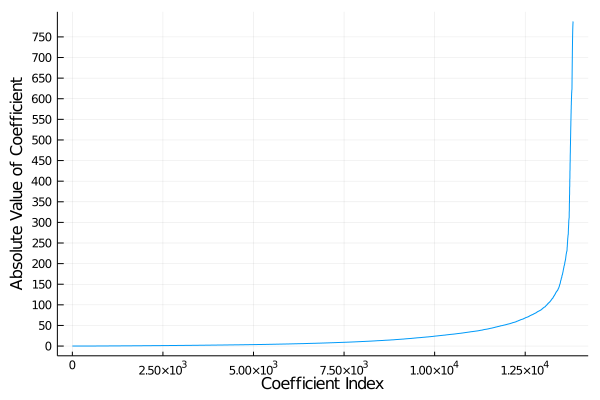

In [7]:
gr()
coef = sort(abs.(accoef_matrix_3d[:]))
plot(coef,legend=:none,yticks=0:50:maximum(coef))
ylabel!("Absolute Value of Coefficient")
xlabel!("Coefficient Index")

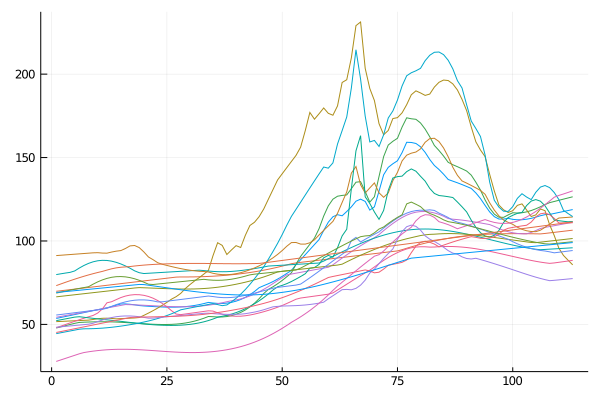

In [8]:
thresh_ls = [acthreshold(accoef_matrix_3d[:,:,i],"soft",40) for i in 1:size(accoef_matrix_3d)[3]]
iac_ls = [iwt_ac(i) for i in thresh_ls]
iac1d = hcat(iac_ls...)'[:,1:113] + fitted

lab = reshape(all_names,1,length(all_names))

gr()
plot(iac1d',legend=:false,label=lab)

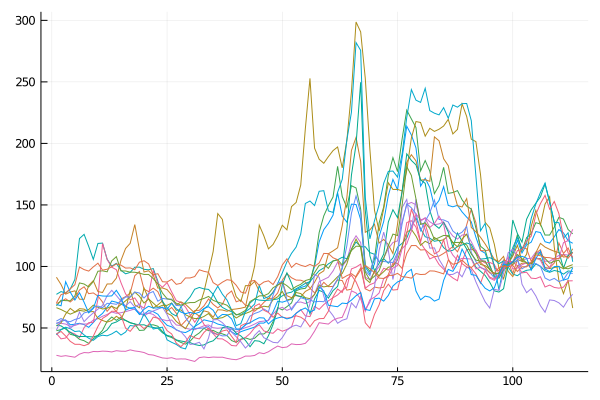

In [9]:
gr()
plot(x',legend=false,label=lab)

In [10]:
#writedlm("thresholded.txt",iac1d,',')